In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import os

folder_path = '/content/drive/MyDrive/blockhouse/CRWV'
all_files = glob.glob(os.path.join(folder_path, '*.csv'))

combined = []

for file in all_files:
    df = pd.read_csv(file)
    df['ts_event'] = pd.to_datetime(df['ts_event'], errors='coerce')
    df = df.dropna(subset=['ts_event'])
    df['minute'] = df['ts_event'].dt.floor('T')
    price_cols = ['bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00']
    df_grouped = df.groupby('minute')[price_cols].mean().reset_index()
    combined.append(df_grouped)

full_df = pd.concat(combined, ignore_index=True)


/tmp/ipython-input-2-2675583606.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T')
/tmp/ipython-input-2-2675583606.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T')
/tmp/ipython-input-2-2675583606.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T')
/tmp/ipython-input-2-2675583606.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T')
/tmp/ipython-input-2-2675583606.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T')
/tmp/ipython-input-2-2675583606.py:14: FutureWarning: 'T' is deprecated and

In [3]:
full_df['spread'] = full_df['ask_px_00'] - full_df['bid_px_00']
full_df['mid_price'] = (full_df['ask_px_00'] + full_df['bid_px_00']) / 2
full_df['imbalance'] = (full_df['bid_sz_00'] - full_df['ask_sz_00']) / (full_df['bid_sz_00'] + full_df['ask_sz_00'])
full_df['beta_t'] = full_df['spread'] / (full_df['bid_sz_00'] + full_df['ask_sz_00'])

full_df = full_df.replace([float('inf'), -float('inf')], pd.NA).dropna()

def compute_gtX(row, X):
    """
    Compute slippage (gt(X)) for a given order size X using row's bid/ask px and sz.
    """
    ask_price = row['ask_px_00']
    ask_size = row['ask_sz_00']
    bid_price = row['bid_px_00']
    bid_size = row['bid_sz_00']
    mid_price = (ask_price + bid_price) / 2

    if X <= ask_size:
        avg_exec_price = ask_price  # Level 1 Book, price is fixed at ask
        slippage = avg_exec_price - mid_price
    else:
        slippage = None  # Not enough liquidity
    return slippage


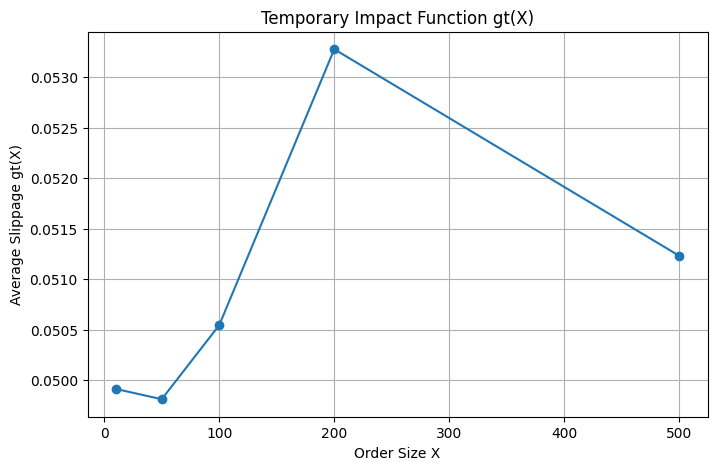

In [4]:
X_values = [10, 50, 100, 200, 500]  # Small order sizes within ask_sz_00
import numpy as np

slippage_data = []

for X in X_values:
    slippages = []
    for idx, row in full_df.iterrows():
        if X <= row['ask_sz_00']:
            slippage = compute_gtX(row, X)
            slippages.append(slippage)
    avg_slippage = np.mean(slippages)
    slippage_data.append((X, avg_slippage))

# Plot gt(X) vs X
import matplotlib.pyplot as plt
X_plot, gtX_plot = zip(*slippage_data)
plt.figure(figsize=(8,5))
plt.plot(X_plot, gtX_plot, marker='o')
plt.xlabel('Order Size X')
plt.ylabel('Average Slippage gt(X)')
plt.title('Temporary Impact Function gt(X)')
plt.grid()
plt.show()


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

features = ['spread', 'imbalance', 'mid_price']
X = full_df[features]
y = full_df['beta_t']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Polynomial
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)


In [6]:
print("Linear Regression:")
print("  MSE:", mean_squared_error(y_test, y_pred_lin))
print("  R²:", r2_score(y_test, y_pred_lin))

print("\nPolynomial Regression (deg=2):")
print("  MSE:", mean_squared_error(y_test, y_pred_poly))
print("  R²:", r2_score(y_test, y_pred_poly))


Linear Regression:
  MSE: 1.1559608768502511e-07
  R²: 0.26683409516408707

Polynomial Regression (deg=2):
  MSE: 1.1404789956038047e-07
  R²: 0.27665344779091783


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest:")
print("  MSE:", mean_squared_error(y_test, y_pred_rf))
print("  R²:", r2_score(y_test, y_pred_rf))


Random Forest:
  MSE: 1.3604688114799317e-07
  R²: 0.1371253412247293


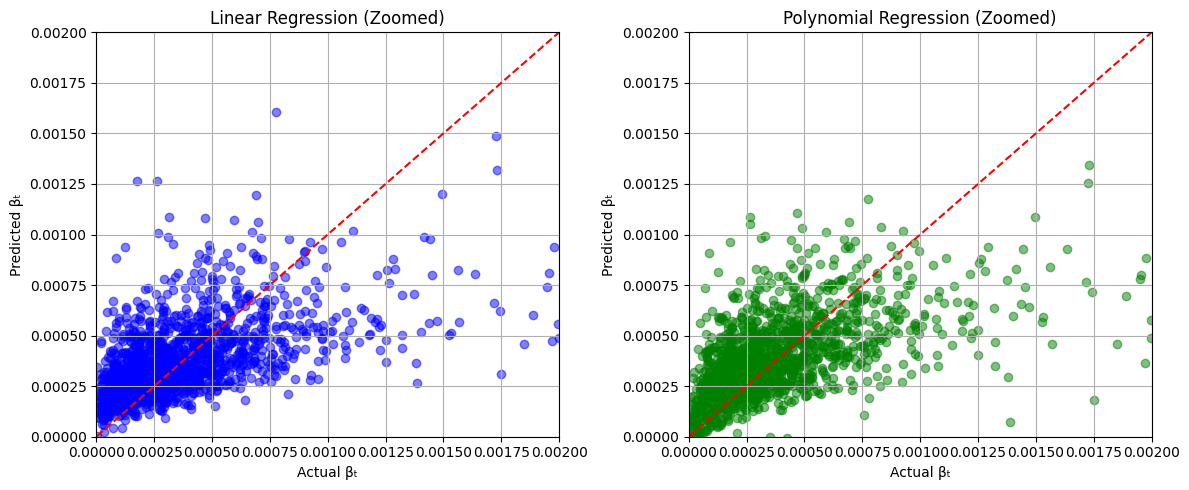

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Linear Regression Zoomed
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lin, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlim(0, 0.002)
plt.ylim(0, 0.002)
plt.xlabel("Actual βₜ")
plt.ylabel("Predicted βₜ")
plt.title("Linear Regression (Zoomed)")
plt.grid()

# Polynomial Regression Zoomed
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlim(0, 0.002)
plt.ylim(0, 0.002)
plt.xlabel("Actual βₜ")
plt.ylabel("Predicted βₜ")
plt.title("Polynomial Regression (Zoomed)")
plt.grid()

plt.tight_layout()
plt.show()


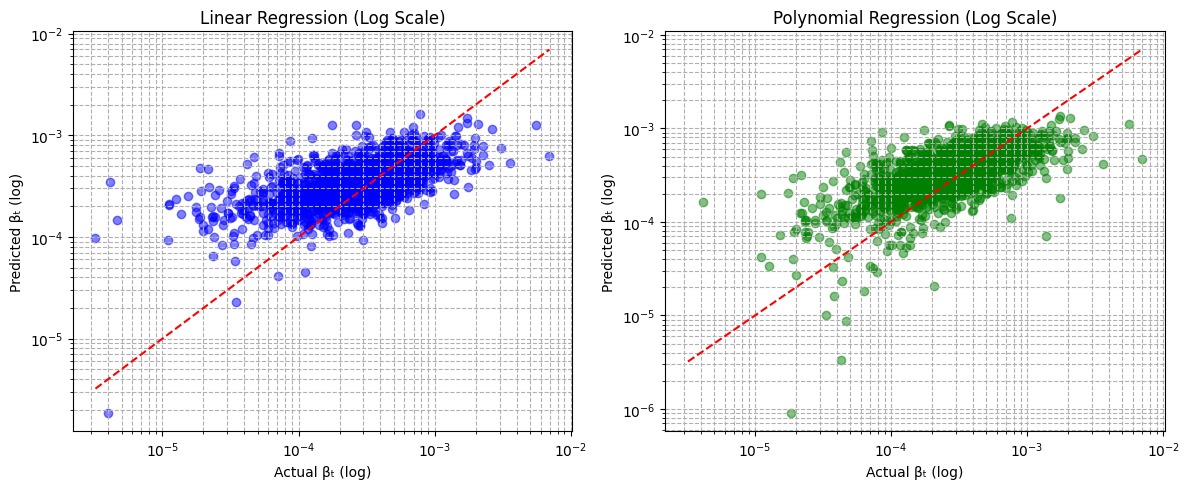

In [9]:
plt.figure(figsize=(12, 5))

# Linear Regression Log Scale
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lin, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Actual βₜ (log)")
plt.ylabel("Predicted βₜ (log)")
plt.title("Linear Regression (Log Scale)")
plt.grid(True, which="both", ls="--")

# Polynomial Regression Log Scale
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Actual βₜ (log)")
plt.ylabel("Predicted βₜ (log)")
plt.title("Polynomial Regression (Log Scale)")
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


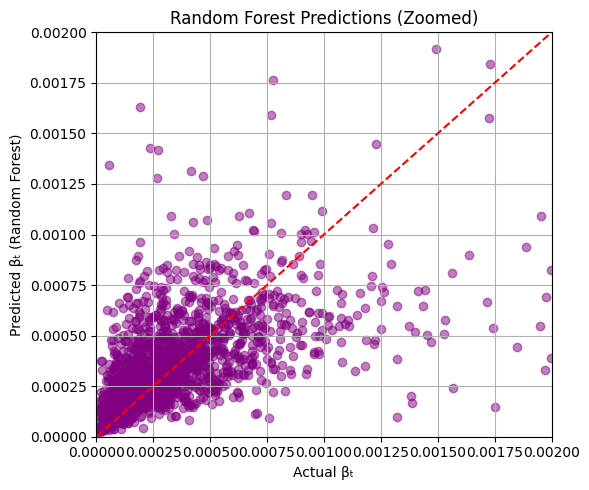

In [10]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual βₜ")
plt.ylabel("Predicted βₜ (Random Forest)")
plt.title("Random Forest Predictions (Zoomed)")

# Zoom in tightly around small values
plt.xlim(0, 0.002)  # adjust as needed
plt.ylim(0, 0.002)
plt.grid()
plt.tight_layout()
plt.show()


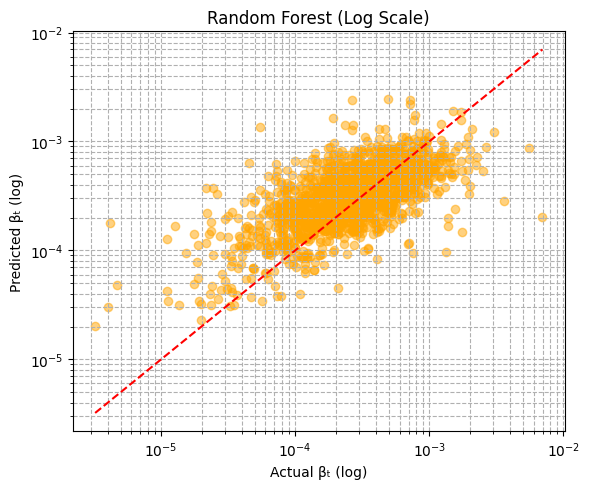

In [11]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Actual βₜ (log)")
plt.ylabel("Predicted βₜ (log)")
plt.title("Random Forest (Log Scale)")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


In [12]:
S = 60000

full_df['gtX'] = full_df.apply(lambda row: compute_gtX(row, 100), axis=1)

full_df = full_df.dropna(subset=['gtX'])

full_df = full_df[full_df['gtX'] > 1e-8]

sum_inverse_gtX = (1 / full_df['gtX']).sum()
full_df['x_t'] = S * (1 / full_df['gtX']) / sum_inverse_gtX



In [15]:
print(day_df[['minute', 'gtX']])
print("gtX Min:", day_df['gtX'].min())
print("gtX Max:", day_df['gtX'].max())


                       minute       gtX
0   2025-05-02 13:30:00+00:00  0.118300
2   2025-05-02 13:32:00+00:00  0.121393
3   2025-05-02 13:33:00+00:00  0.066050
4   2025-05-02 13:34:00+00:00  0.049855
9   2025-05-02 13:39:00+00:00  0.037177
..                        ...       ...
385 2025-05-02 19:55:00+00:00  0.017672
386 2025-05-02 19:56:00+00:00  0.016392
387 2025-05-02 19:57:00+00:00  0.017086
388 2025-05-02 19:58:00+00:00  0.016839
389 2025-05-02 19:59:00+00:00  0.009566

[233 rows x 2 columns]
gtX Min: 0.008267605633804465
gtX Max: 0.12139344262295282


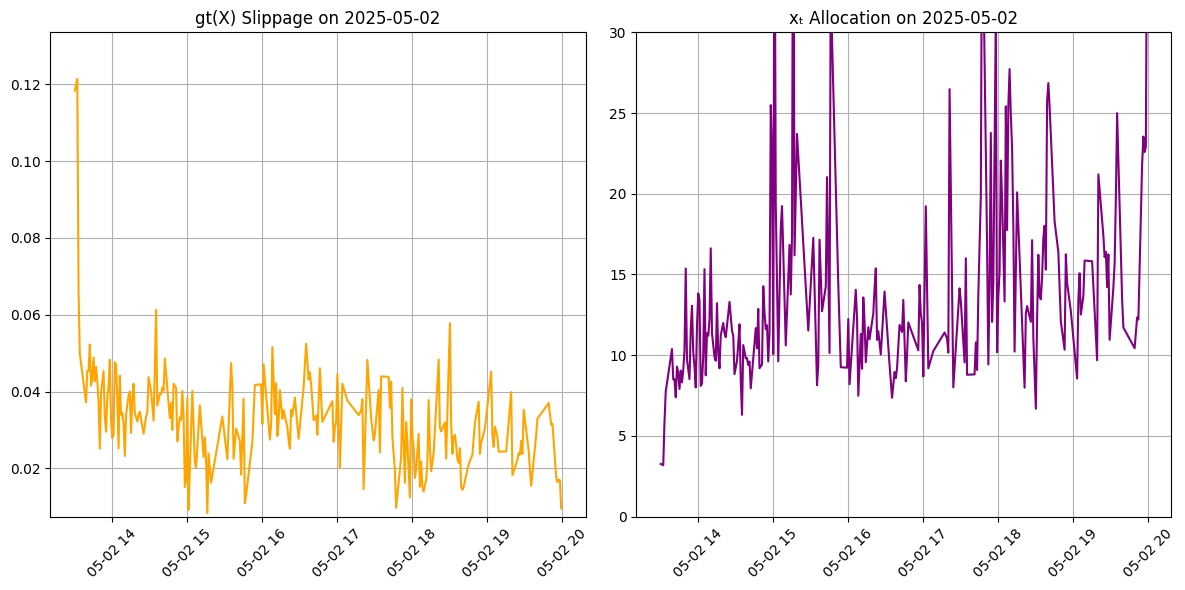

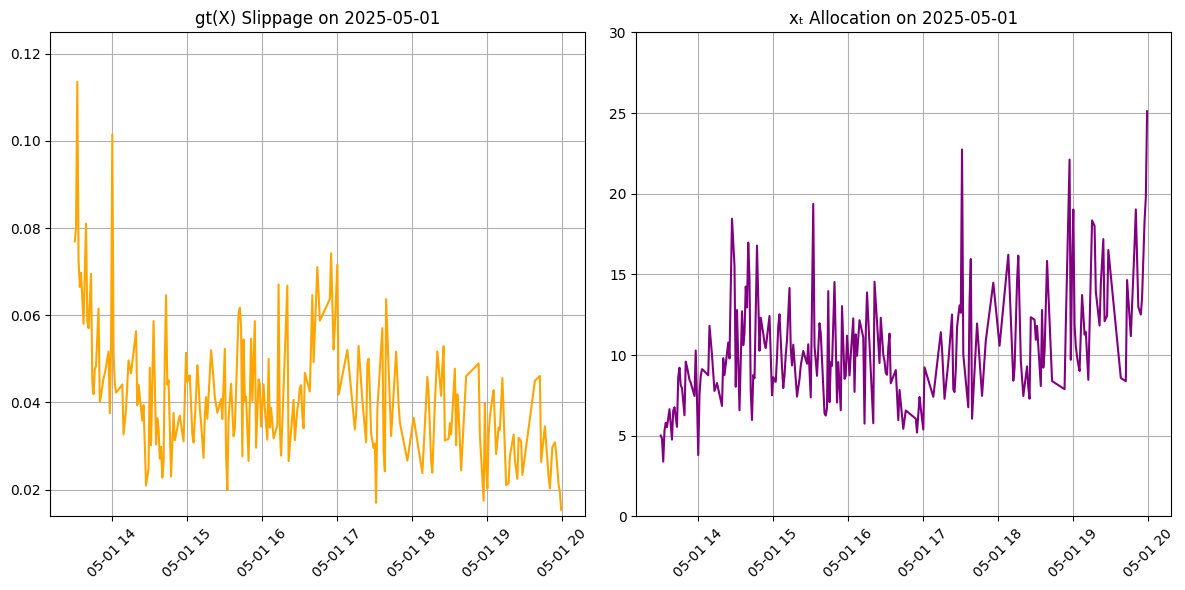

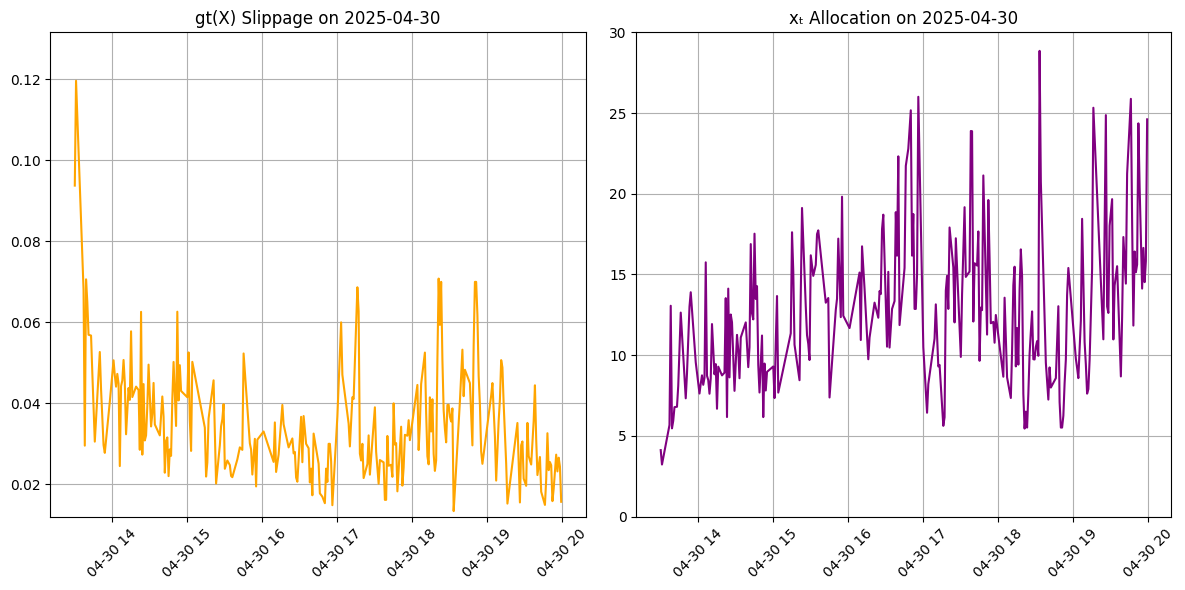

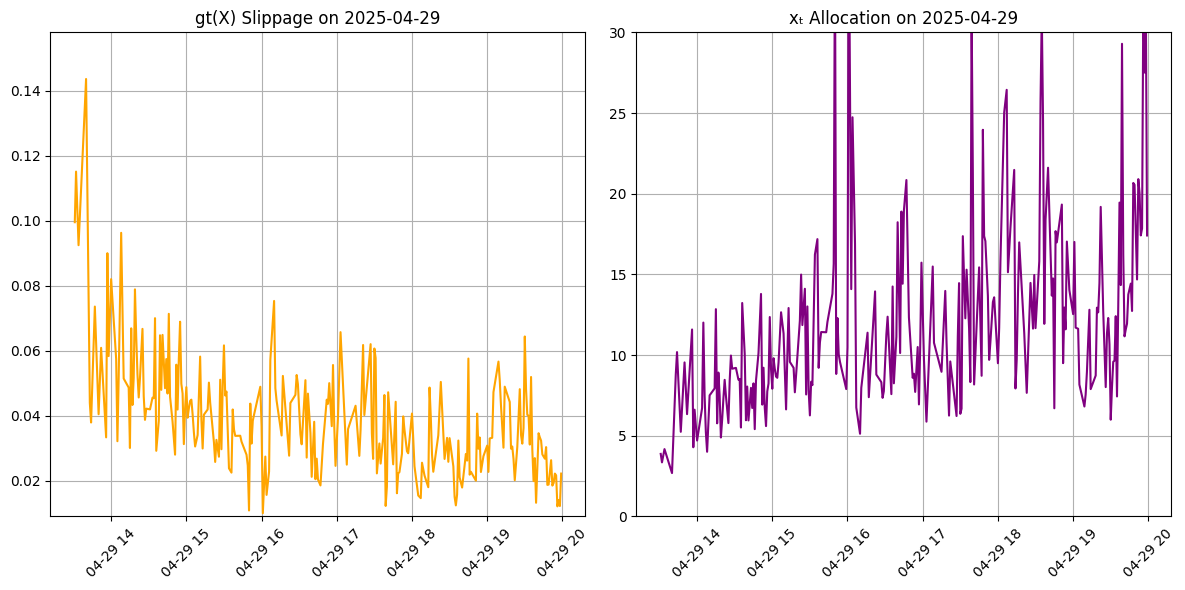

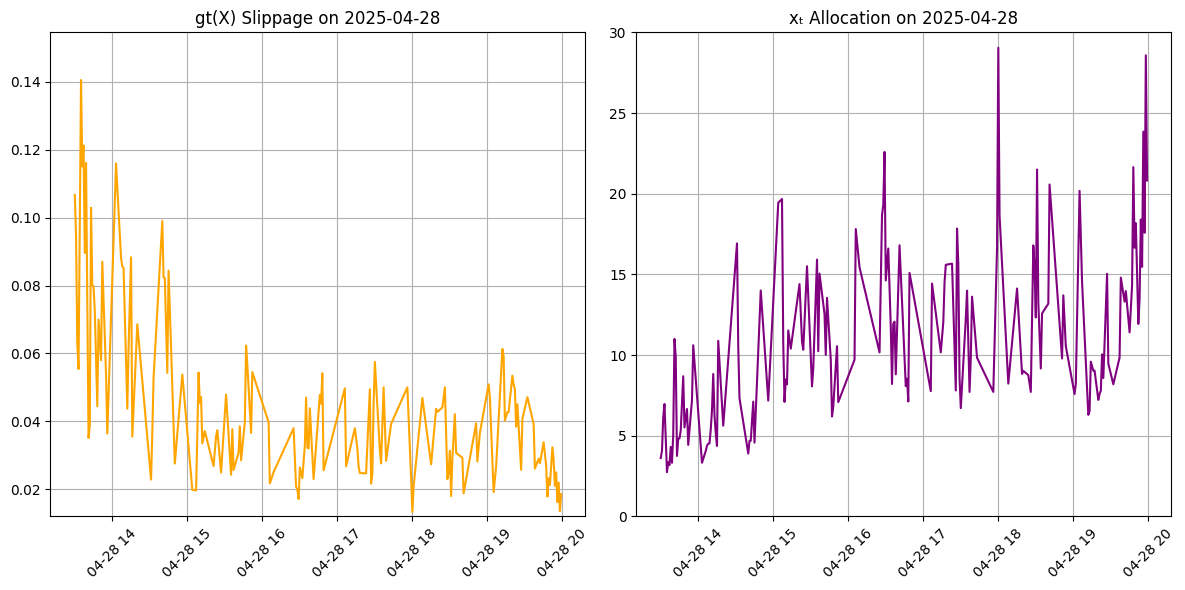

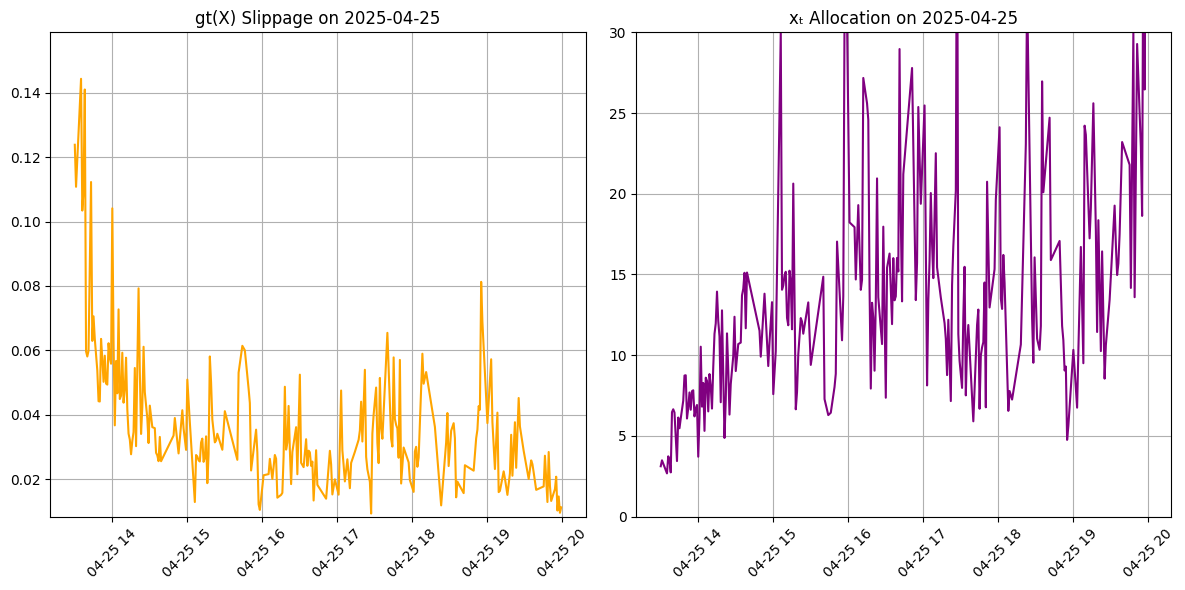

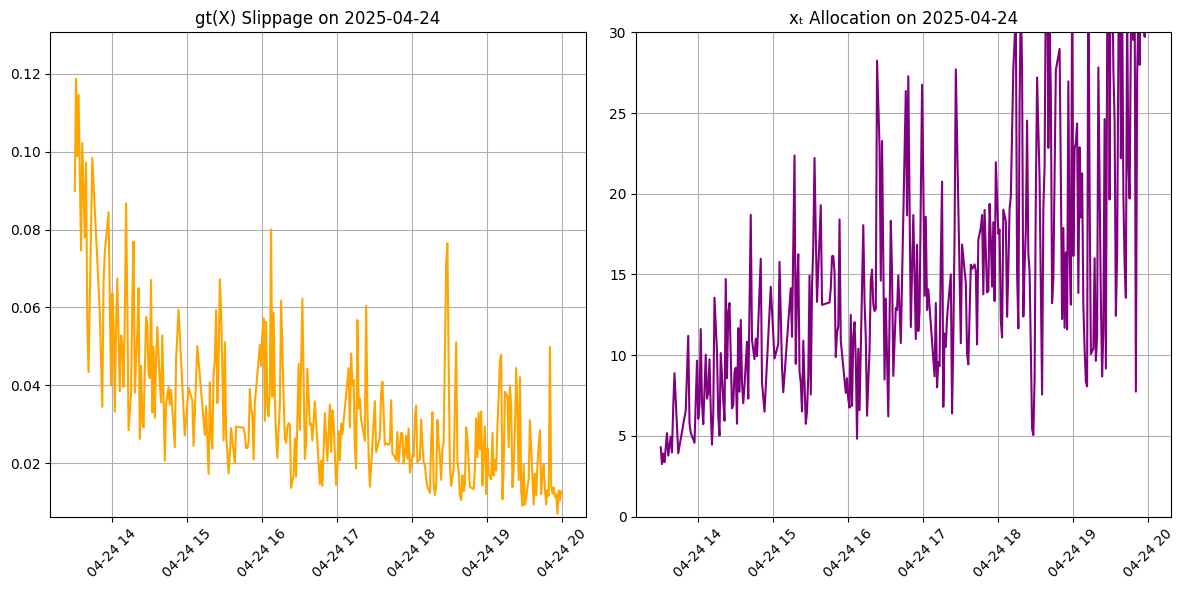

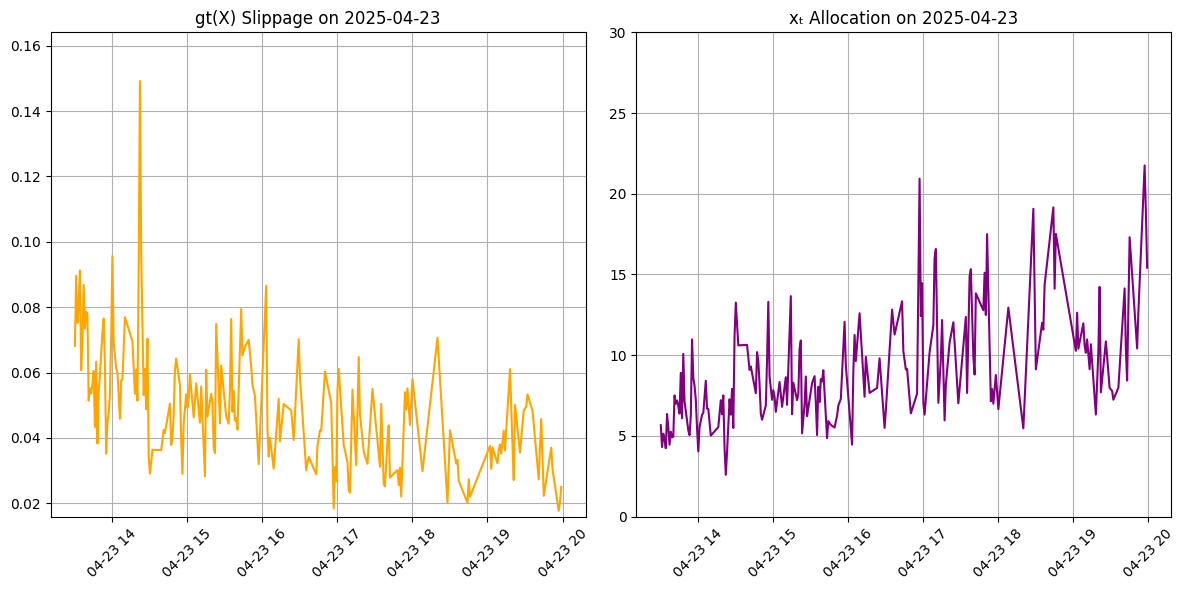

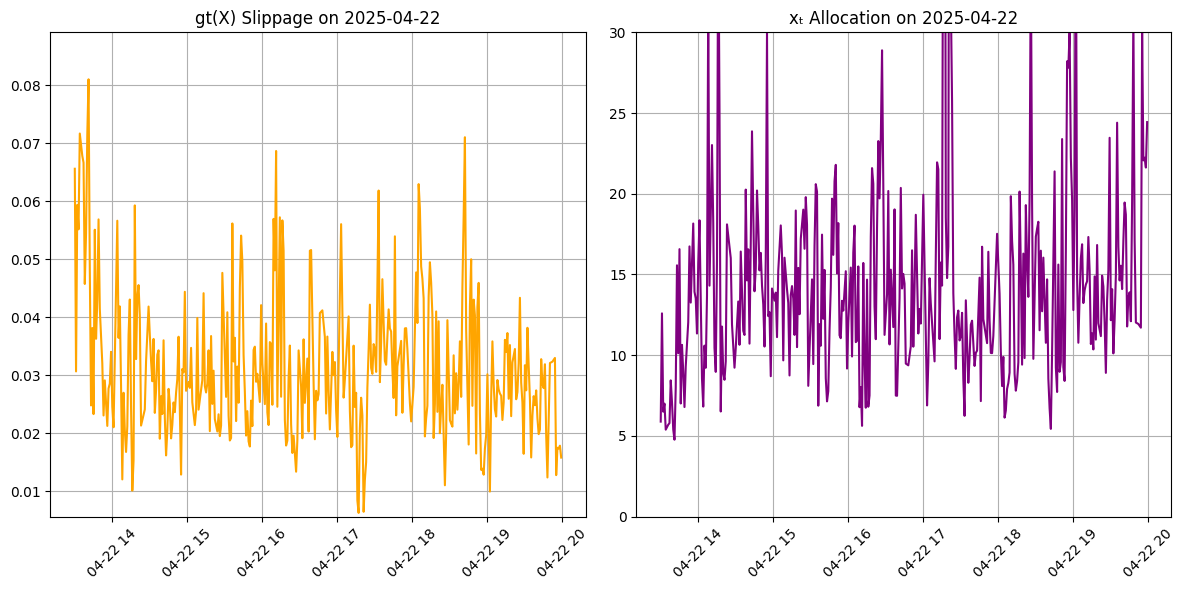

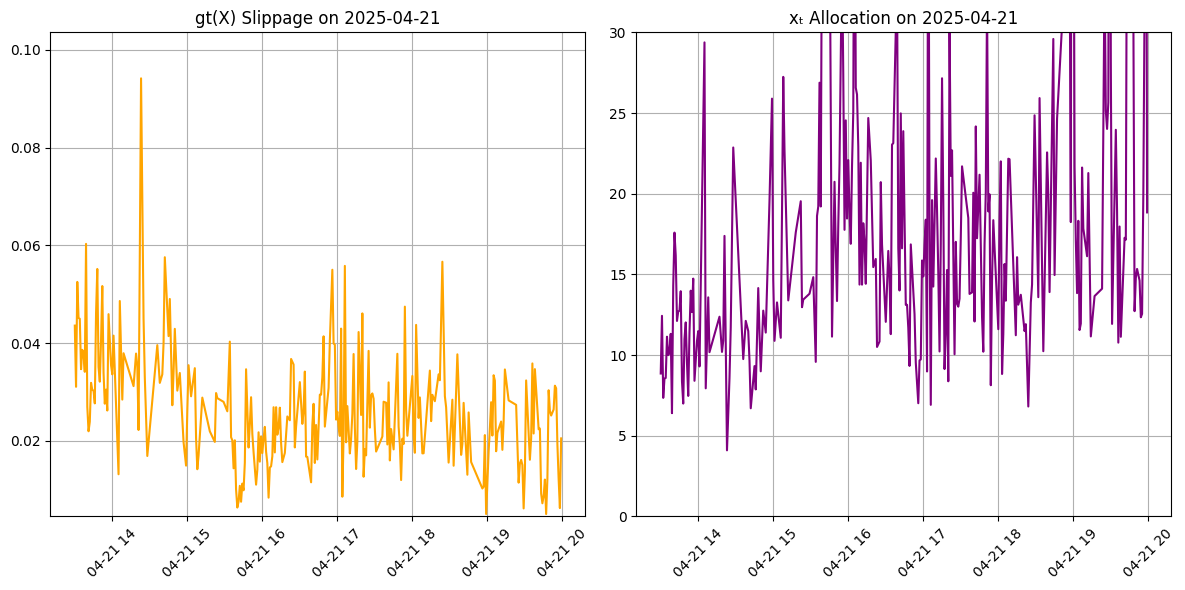

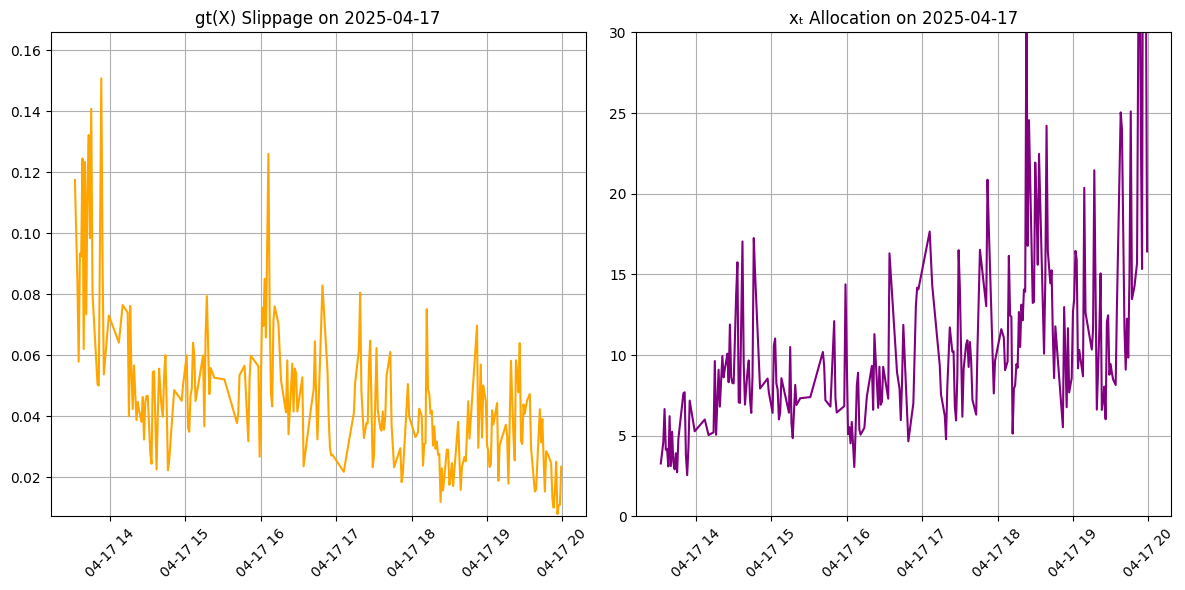

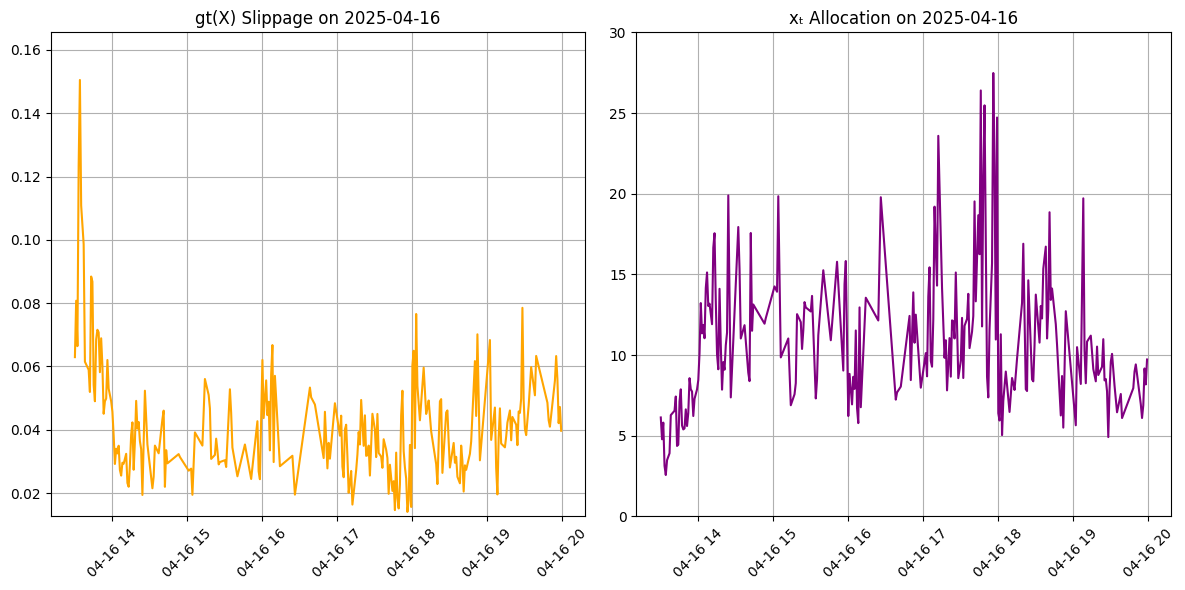

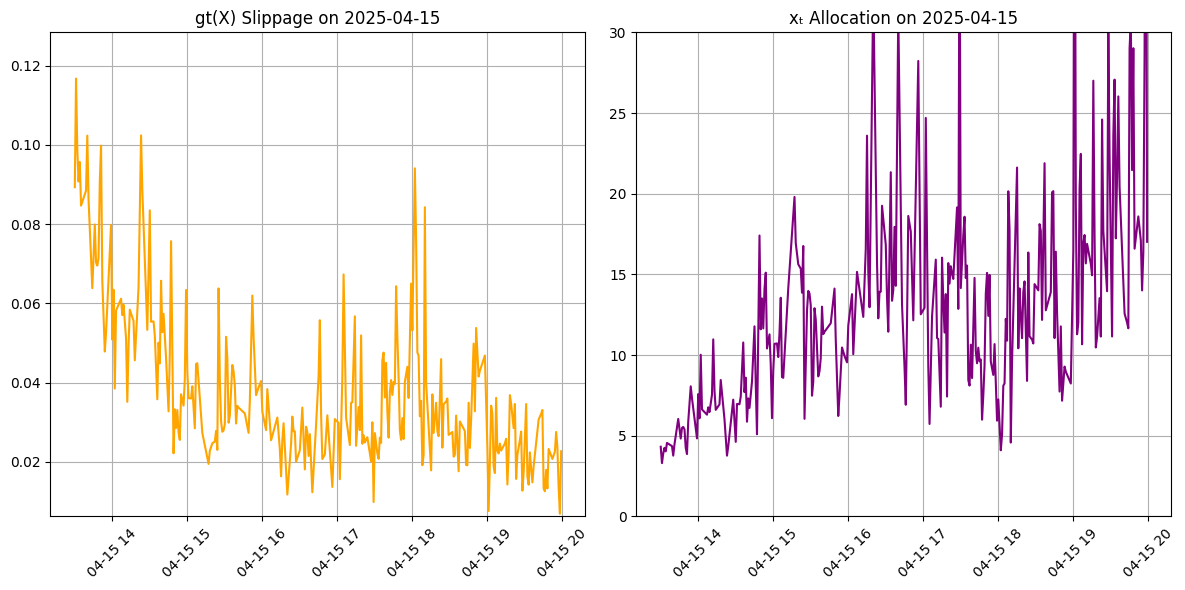

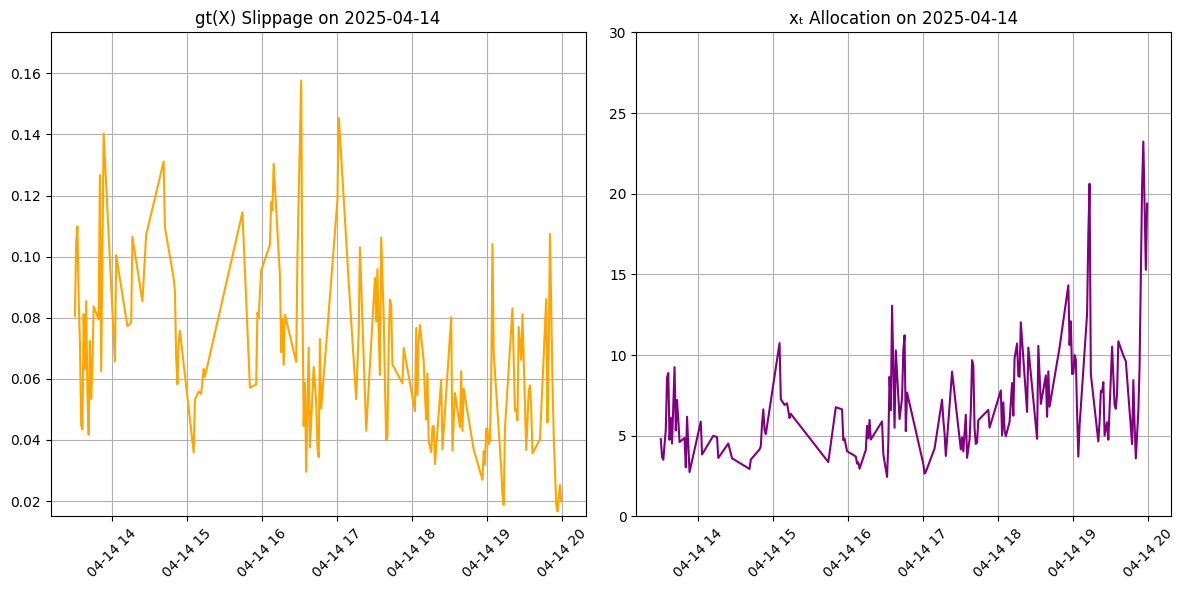

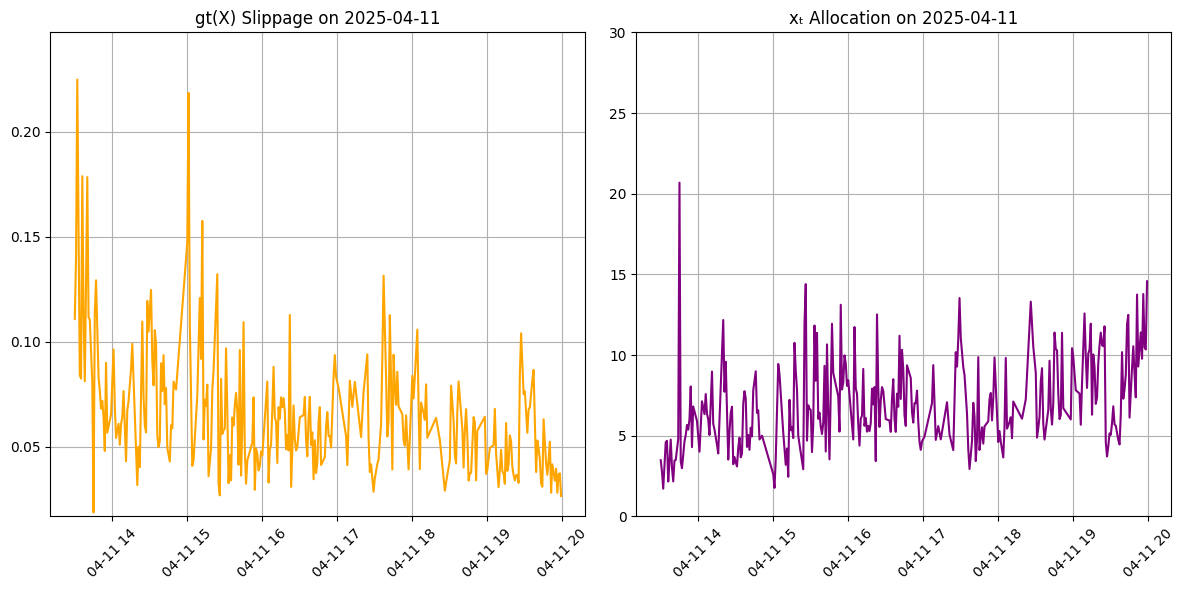

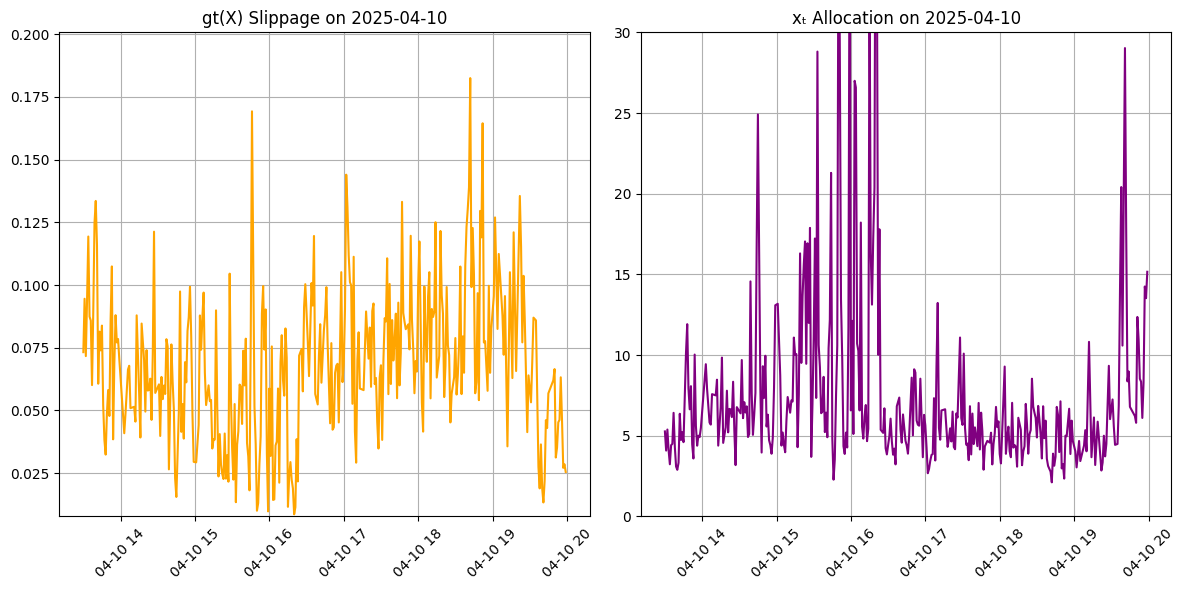

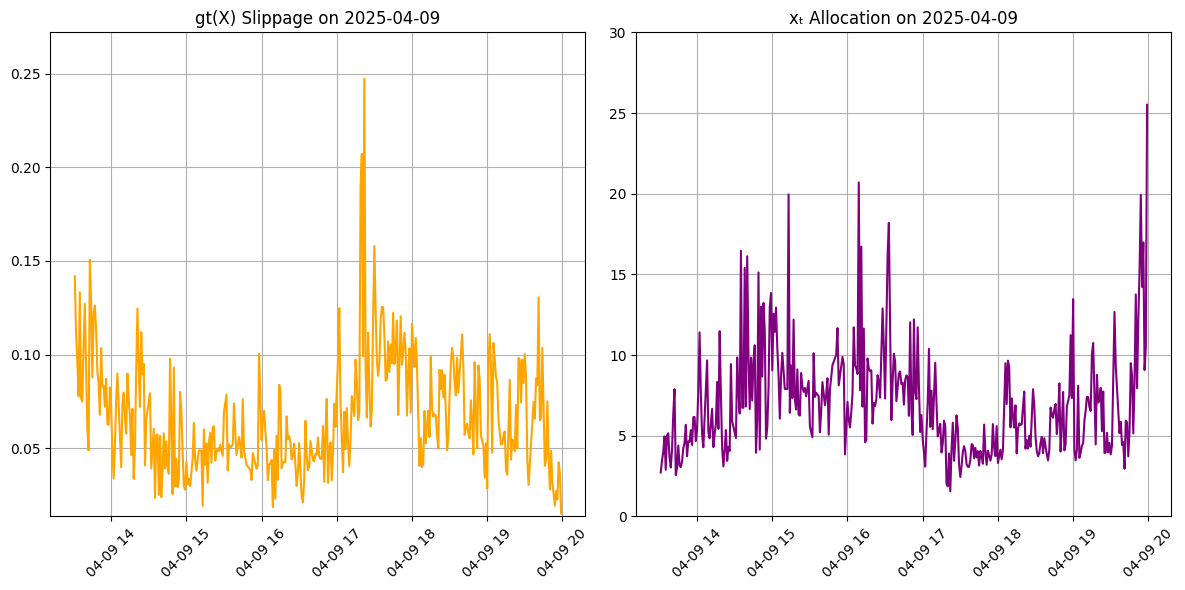

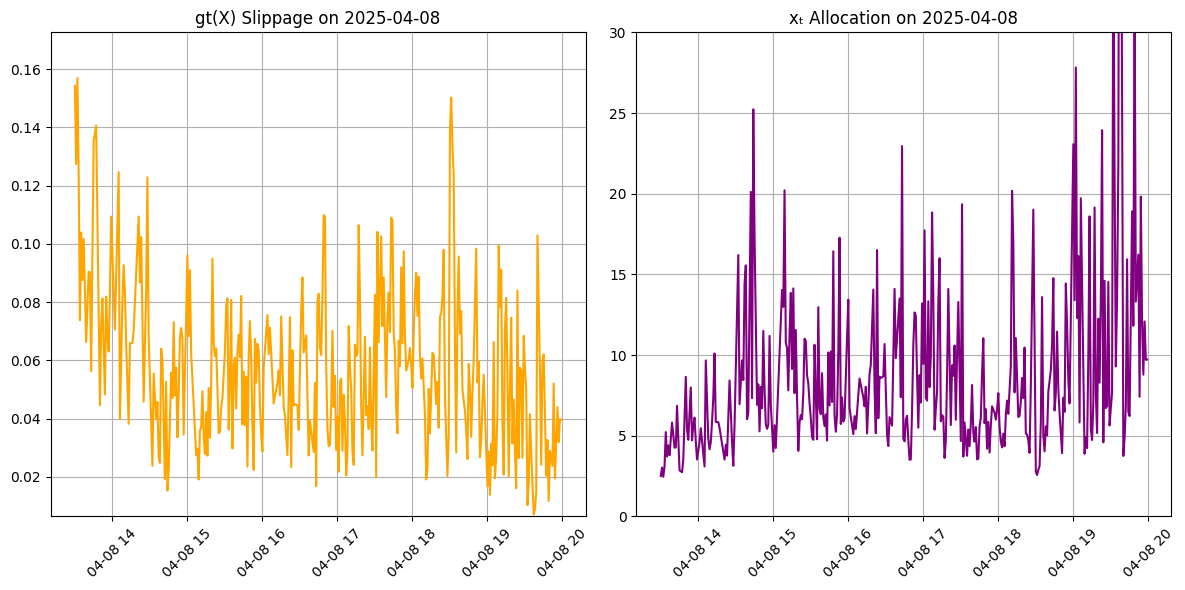

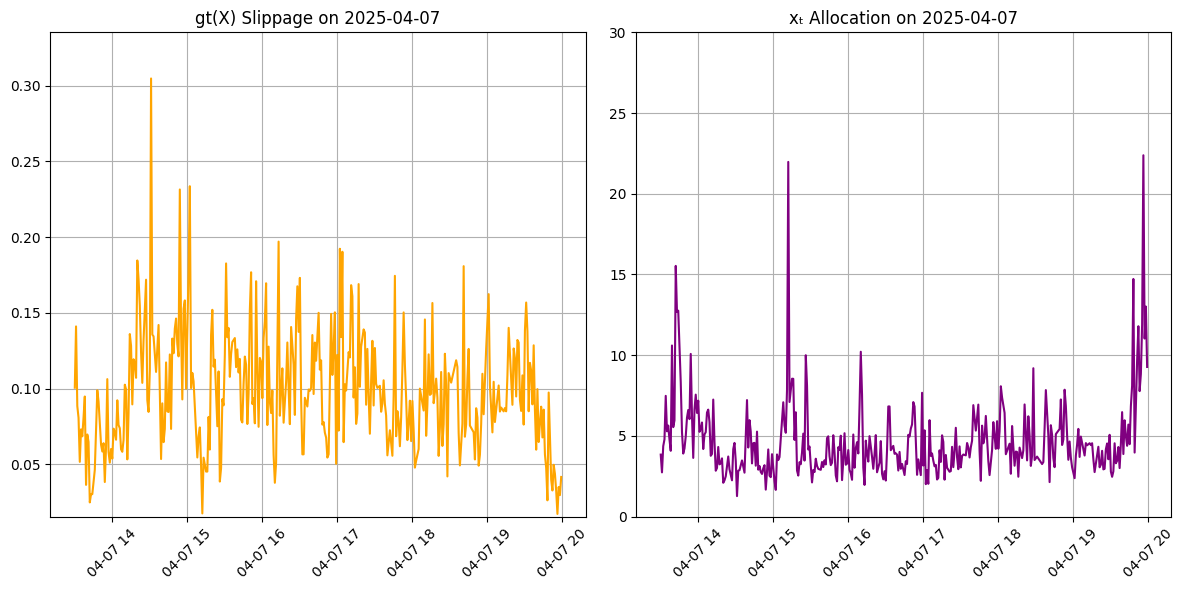

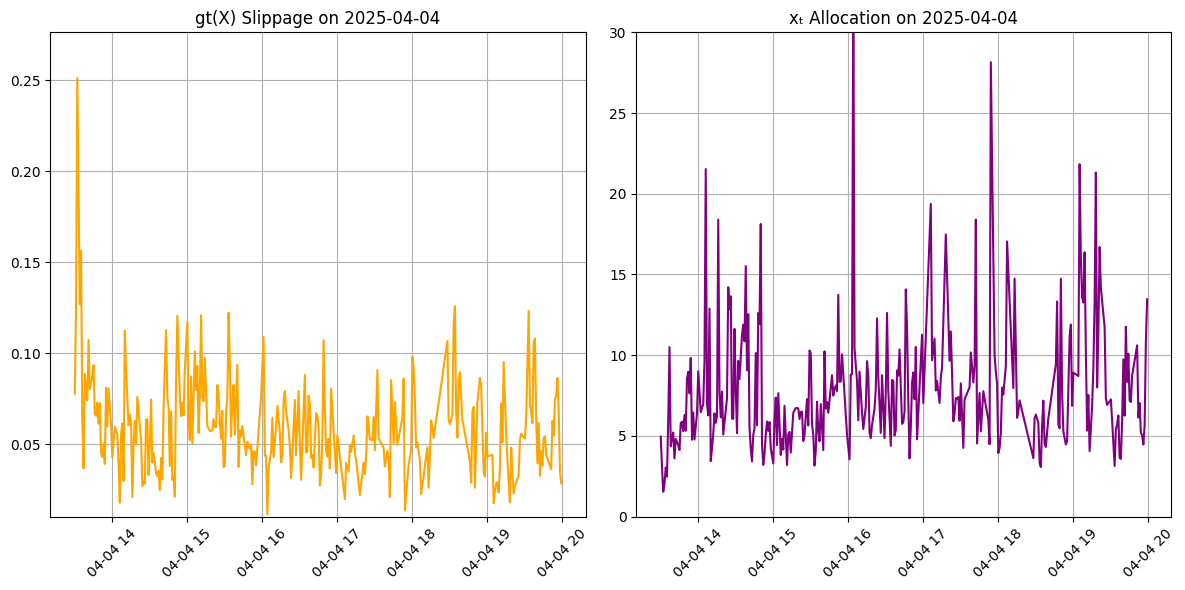

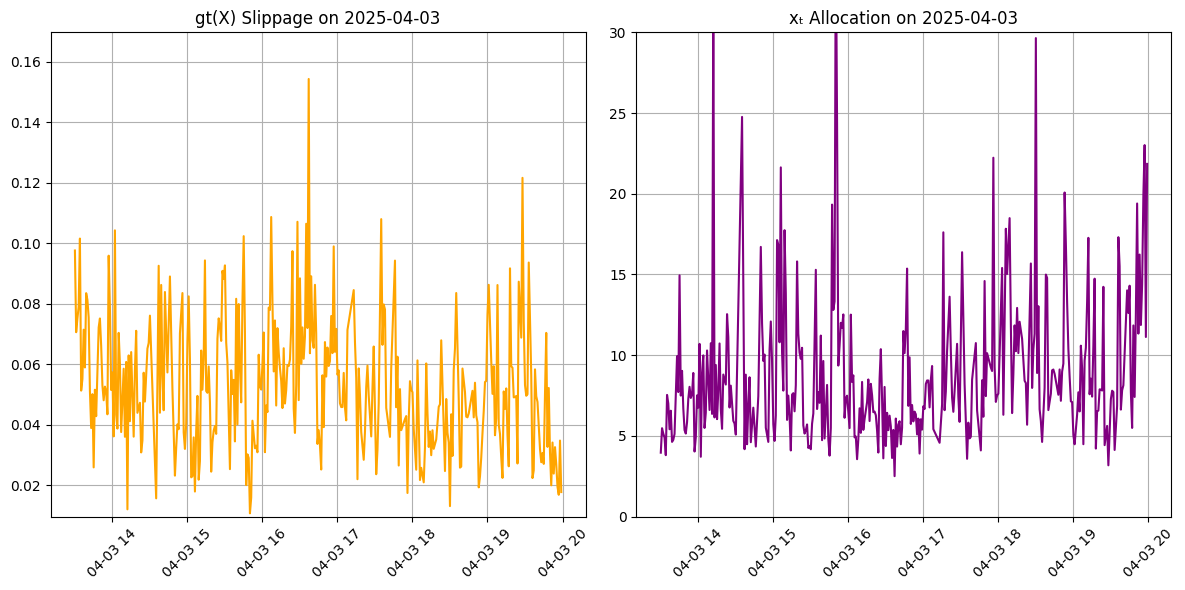

In [16]:
import matplotlib.pyplot as plt

full_df['date'] = full_df['minute'].dt.date

xt_ylim = (0, 30)

unique_dates = full_df['date'].unique()

for date in unique_dates:
    day_df = full_df[full_df['date'] == date]

    if day_df['gtX'].isna().all():
        continue  # Skip if gtX is completely NaN

    plt.figure(figsize=(12, 6))

    # LEFT: gt(X) per minute (Auto Y-axis)
    plt.subplot(1, 2, 1)
    plt.plot(day_df['minute'], day_df['gtX'], color='orange')
    plt.ylim(day_df['gtX'].min() * 0.9, day_df['gtX'].max() * 1.1)
    plt.title(f"gt(X) Slippage on {date}")
    plt.xticks(rotation=45)
    plt.grid()

    # RIGHT: Allocation xₜ per minute
    plt.subplot(1, 2, 2)
    plt.plot(day_df['minute'], day_df['x_t'], color='purple')
    plt.ylim(xt_ylim)
    plt.title(f"xₜ Allocation on {date}")
    plt.xticks(rotation=45)
    plt.grid()

    plt.tight_layout()
    plt.show()


In [ ]:
full_df.to_csv("final_combined_with_features.csv", index=False)
print("✅ Saved to final_combined_with_features.csv")


✅ Saved to final_combined_with_features.csv
